# autocorrelation parametric estimation with maximum likehood: Gaussian case

MLE is sensitivite to strong autocorrelations or wrong autocorrelations which induce numerical imprecisions:

- Basak et al. 2021
- Andrianakis et al. 2012
- github issues: [1](https://github.com/GPflow/GPflow/issues/553#issuecomment-345001251), [2](https://github.com/nrontsis/PILCO/issues/46)

---
## univariate case

We consider a real time series $u(t)$ and aim at estimating it's mean $\mu(t) = \langle u(t) \rangle$, it's variance along with parameters describing its autocorrelation $\sigma(t, t')$ (e.g. time scale of decay), where:

\begin{align}
\sigma(t, t') = \big \langle (u(t) - \mu) (u(t') - \mu) \big \rangle
\end{align}

We'll assume that the time series follows a Gaussian distribution.
**This Gaussian assumption may/should be verified in practice**.
We'll also assume now that data is discrete such that the marginal probability distribution of the observed time-series data is given by:

\begin{align}
P[\mathbf{u}] = 
\frac{\exp \Big ( -\frac{1}{2} [ \mathbf{u} - \mathbf{m} ]^T \boldsymbol{\Sigma}^{-1} [ \mathbf{u} - \mathbf{m} ] \Big )  }
{\sqrt{(2\pi)^N |\mathbf{\boldsymbol{\Sigma}}|}},
\end{align}

where $N$ is the number of data points, $\mathbf{u}$ is the velocity time series, $\mathbf{m}$ is the sampled mean, and $\boldsymbol{\Sigma}$ is the sampled autocorrelation:

\begin{align}
\mathbf{U}_i &=u(t_i), \\
\mathbf{M}_i &=\mu(t_i), \\
\boldsymbol{\Sigma}_{i,j} &= \sigma(t_i,t_j).
\end{align}

where mean and autocorrelation may not be stationary (in general, they will be below).
The log-likelhood function is then:

\begin{align}
L = -\frac{1}{2} \log | \boldsymbol{\Sigma} | 
- \frac{1}{2} [ \mathbf{u} - \mathbf{m} ]^T \boldsymbol{\Sigma}^{-1} [ \mathbf{u} - \mathbf{m} ].
\end{align}

Note that we dropped the $2\pi$ factor here but the combinations of different time series with unequal length may require to consider its contribution.
We assume from now on that statistics are stationary: $\mu(t)=\mu$, $\sigma(t,t')=\sigma(t'-t)$.
We'll also assume the autocorrelation may be written as $\sigma(t'-t)=\sigma_0 c(t'-t)$, where $\sigma_0$ is the variance of the signal.
The likelihood is then written as:

\begin{align}
L = -\frac{1}{2} \log | \boldsymbol{C} | 
-\frac{N}{2} \log \sigma_0
- \frac{1}{2\sigma_0} [ \mathbf{u} - \mu\mathbb{1} ]^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ]
\end{align}



The goal is now to find the maximum likelihood over $\mu$, $\sigma_0$ and the parameters describing $c$.
The process of finding this maximum may be decomposed into maximizations over $\mu$ and $\sigma_0$ and then autocorrelation parameters.

### profiling the mean

\begin{align}
\frac{\partial L}{\partial \mu} &= \frac{1}{\sigma_0} \mathbb{1}^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ],
\end{align}

which, when equalled to zero, leads to the following value for the mean:

\begin{align}
\hat{\mu} &= \frac{\mathbb{1}^T \boldsymbol{C}^{-1} \mathbf{u}}{\mathbb{1}^T \boldsymbol{C}^{-1} \mathbb{1}}, \\
&= \frac{\sum_i w_i u_j}{\sum_{i} w_i}, \\
w_i &= \sum_{j} c_{ij}^{-1}.
\end{align}

Observed Fisher information (Pawitan p32) is:

\begin{align}
I &= -\frac{\partial^2 L}{\partial \mu^2}, \\
&= \frac{1}{\sigma_0} \mathbb{1}^T \boldsymbol{C}^{-1} \mathbb{1}^T
= \frac{1}{\sigma_0} \sum_{ij} c_{ij}^{-1},
\end{align}

And the asymptotic standard error associate with the mean is thus:

\begin{align}
SE(\hat{\mu}) &= I^{-1/2} = \sqrt{\frac{\sum_{ij} c_{ij}^{-1}}{\sigma_0}}.
\end{align}


### profiling the variance

Differentiating with respect to the variance $\sigma_0$ leads to:

\begin{align}
\partial_{\sigma_0} L = 
-\frac{N}{2\sigma_0}
+ \frac{1}{2\sigma_0^2} [ \mathbf{u} - \mu\mathbb{1} ]^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ]
\end{align}

This is null for:

\begin{align}
\hat{\sigma}_0 = \frac{1}{N} [ \mathbf{u} - \mu\mathbb{1} ]^T \boldsymbol{C}^{-1} [ \mathbf{u} - \mu\mathbb{1} ],
\end{align}

which is the sample correlation and depends on yet to be determined autocorrelation parameters.

Observed Fisher information is:

\begin{align}
I &= -\frac{\partial^2 L}{\partial \sigma_0^2}, \\
&= \frac{N}{\hat{\sigma}_0^2},
\end{align}

Leading to the following asymptotic error:

\begin{align}
SE(\hat{\sigma}_0) &= \frac{\hat{\sigma}_0}{\sqrt{N}}.
\end{align}




### maximizing the likelihood over autocorrelation parameters

It is now possible to maximized the "profile" likelihood (i.e. that with mean and variance optimal values have been plugged, see Pawitan p61).


### illustration

Generate a 100 day time series with a 10 days decorrelation timescale

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

from numpy.linalg import inv, slogdet
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy import linalg
import statsmodels.api as sm

import matplotlib.pyplot as plt

import sstats.tseries as ts
import sstats.sigp as sigp

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#ts.exp_autocorr?

In [3]:
c_gaussian = lambda dt, T: np.exp(-abs(dt/T)**2)

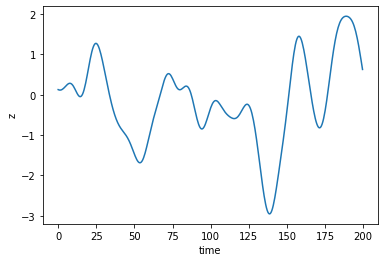

In [4]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale

delta_T = 200 # time series length
dt = 3/24 # hours, sampling interval

if True:
    u = ts.general_autocorr((delta_T, dt),
                            lambda tau: c_gaussian(tau, T),
                            np.sqrt(sigma0),
                            draws=1,
                            seed=0)
else:
    u = ts.exp_autocorr((delta_T, dt), T, 
                        np.sqrt(sigma0), 
                        #burnin=int(10*T/dt),
                        draws=1,
                        seed=0,
                       )
u = (mu + u).compute()

# debug: subsample
u = u.isel(time=slice(0,None,4))

# total number of points
N = u.time.size # = delta_T/dt 

# store for later use
mu_true = mu
sigma0_true = sigma0
T_true = T
#
u0 = u

# plot
u.plot.line(x="time")

Let's verify the decorrelation timescale is about 10 days

---

# start with MLE

In [5]:
u = u0.values
t = u0.time.values
c = c_gaussian
T = 5
jitter=1e-8

jitters_exp = np.arange(1.,20)

In [6]:
N = u.size

C = c(t[:,None]-t[None,:], T)
C_jitter = C + np.eye(C.shape[0])*jitter
#L = np.linalg.cholesky(C) # LinAlgError: Matrix is not positive definite
#L = np.linalg.cholesky(C_jitter)
L = linalg.cholesky(C_jitter, lower=True)
#L, lower = linalg.cho_factor(C_jitter, lower=True)
np.allclose(np.dot(L, L.T.conj()), C) # default: rtol=1e-05, atol=1e-0

True

**Sensitivity to jitter:**

In [7]:
result = []
for j in jitters_exp:
    try:
        _C = C + np.eye(C.shape[0])* (10**(-j))
        _L = linalg.cholesky(_C, lower=True)
        #_L, lower = linalg.cho_factor(_C)
        result.append(np.linalg.cond(_L))
    except:
        result.append(-1)
condition_num = pd.Series(result, index=jitters_exp)

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

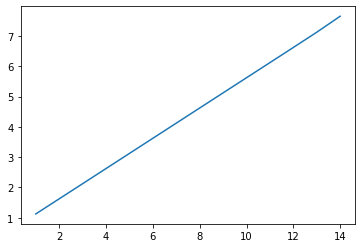

In [8]:
np.log10(condition_num).plot()

---
### mean

In [9]:
def solve_mu(C, u, L_solve=None):
    """ Solve fo the mean
    """
    ones = np.ones(C.shape[0])
    if L_solve is None:
        L_solve = linalg.cho_factor(C, lower=True)
    w = linalg.cho_solve(L_solve, ones)
    mu = np.dot(w, u) / w.sum()
    return mu, w, L_solve

mean mu = -1.39e-01


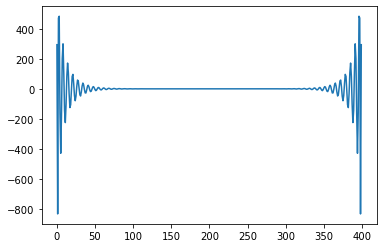

In [10]:
mu, w, L_solve = solve_mu(C_jitter, u, L_solve=None)
plt.plot(w)
print(f"mean mu = {mu:.2e}")

**sensitivity to jitter**

In [11]:
result = []
for j in jitters_exp:
    try:
        _mu, _w, _L_solve = solve_mu( C + np.eye(C.shape[0])* (10**(-j)) , u)
        #plt.figure()
        #plt.plot(_w)
        result.append(_mu)
    except:
        result.append(np.NaN)
mu_jitters = pd.Series(result, index=jitters_exp)

Text(0.5, 0, 'jitter exp')

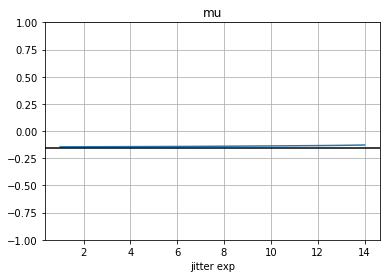

In [12]:
fig, ax = plt.subplots(1,1)
mu_jitters.plot()
ax.axhline(u.mean(), color="k")
#ax.set_ylim(-10, 10)
ax.set_ylim(-1, 1)
ax.grid()
ax.set_title("mu")
ax.set_xlabel("jitter exp")

---
### variance

Override estimate of the mean with the sample mean for now.

In [13]:
mu_MLE = mu
mu = np.mean(u)
#mu = mu_true
print(f"sample mean = {mu:.2f} vs {mu_MLE:.2f} for MLE")

up = u - mu

sample mean = -0.16 vs -0.14 for MLE


In [14]:
def solve_sigma0(C, up, L_solve=None):
    """ Solve fo the mean
    """
    N = C.shape[0]
    if L_solve is None:
        L_solve = linalg.cho_factor(C, lower=True)
    Cinv_u = linalg.cho_solve(L_solve, up)
    sigma0 = np.dot(up, Cinv_u) / N
    return sigma0, L_solve

In [15]:
sigma0, _ = solve_sigma0(C, up, L_solve=L_solve)
print(f"sigma0 = {sigma0:.2f}")

sigma0 = 0.07


Sample variance:

In [16]:
np.var(up)

1.1226946702067568

In [17]:
result = []
for j in jitters_exp:
    try:
        _var, _ = solve_sigma0( C + np.eye(C.shape[0]) * 10**(-j) , up)
        result.append(_var)
    except:
        result.append(np.NaN)
var_jitters = pd.Series(result, index=jitters_exp)

Text(0.5, 0, 'jitter exp')

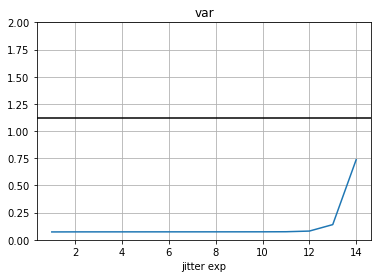

In [18]:
fig, ax = plt.subplots(1,1)
var_jitters.plot()
ax.axhline(up.var(), color="k")
#ax.set_ylim(0, 10)
ax.set_ylim(0, 2)
ax.grid()
ax.set_title("var")
ax.set_xlabel("jitter exp")

---
### estimate log likelihood and parameter

Fix variance (`sigma0`) for now

In [19]:
sigma0 = u.var()
#sigma0 = sigma0_true

**!!! numpy slogdet leads to a result different than what is derived from the Cholesky decomposition**

In [22]:
s, logdet = np.linalg.slogdet(C)
logdet

-10079.871201757769

In [34]:
logdet = 2*np.log(np.diag(L_solve[0])).sum()

In [35]:
pL = -1/2 * logdet - N/2*np.log(sigma0) - 1/2/sigma0 *sigma0*N
pL

2602.5286651664273

In [21]:
T_all = np.arange(1,20)
jitter_min = -10.

In [22]:
sigp.likelihood(u0, u0.time, c, T, jitter=jitter_min)

{'L': 3774.020533948359,
 'mu': -0.1365984253653175,
 'sigma0': 0.07345364495622107,
 'jitter': -10.0,
 'mu_err': 18.20386942668565,
 'sigma0_err': 0.003672682247811054}

In [23]:
# old approach, should use likelihood_xr now
if False:
    ds = xr.Dataset(coords=dict(T=("T", T_all)))
    ds["L"] = ("T", sigp.likelihood_vec(u0, u0.time, c, T_all, jitter=jitter_min))
    ds["L_mu"] = ("T", sigp.likelihood_vec(u0, u0.time, c, T_all, mu=mu_true, jitter=jitter_min))
    ds["L_mu_sigma0"] = ("T", sigp.likelihood_vec(u0, u0.time, c, T_all, mu=mu_true, sigma0=sigma0_true, jitter=jitter_min))
    
    fig, ax = plt.subplots(1,1)
    ds.L.plot(label="L")
    ds.L_mu.plot(label="L_mu")
    ds.L_mu_sigma0.plot(label="L_mu_sigma0")
    ax.legend()
    ax.grid()    

In [24]:
ds = sigp.likelihood_xr(u0, c, dict(T=T_all), jitter=-10)
ds_mu = sigp.likelihood_xr(u0, c, dict(T=T_all), mu=mu_true, jitter=-10)
ds_mu_sigma0 = sigp.likelihood_xr(u0, c, dict(T=T_all), mu=mu_true, sigma0=sigma0_true, jitter=-10)

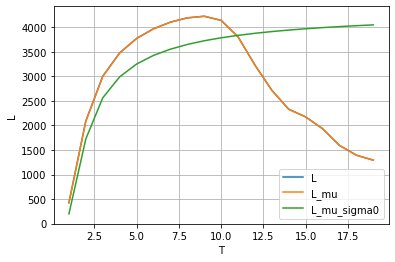

In [25]:
fig, ax = plt.subplots(1,1)
ds.L.plot(label="L")
ds_mu.L.plot(label="L_mu")
ds_mu_sigma0.L.plot(label="L_mu_sigma0")
ax.legend()
ax.grid()    

--- 

### with more draws

In [26]:
u = ts.general_autocorr((delta_T, dt),
                        lambda tau: c_gaussian(tau, T_true),
                        np.sqrt(sigma0),
                        draws=10,
                        seed=0).persist()

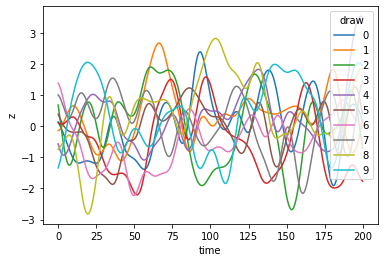

In [27]:
u.plot.line(x="time");

In [28]:
ds = sigp.likelihood_xr(u, c, dict(T=T_all), jitter=-10).persist()

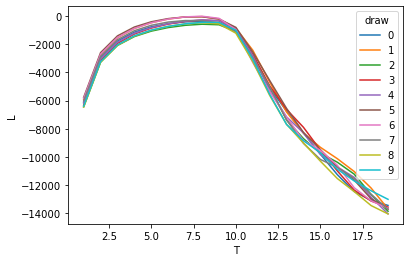

In [36]:
(ds.L-ds.L.max()).plot.line(x="T");

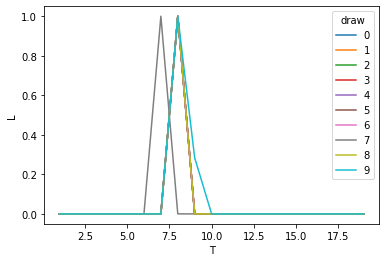

In [39]:
np.exp(ds.L-ds.L.max("T")).plot.line(x="T");

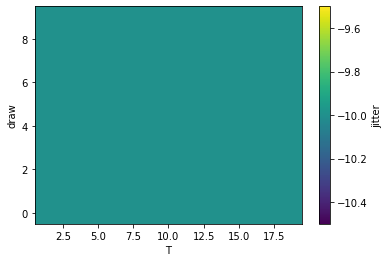

In [30]:
ds.jitter.plot();